In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
import os
from PIL import Image

In [ ]:
dataset_folder = '/content/drive/MyDrive/Tyre Quality'
img_path = '/content/drive/MyDrive/Tyre Quality/training/defective/Defective (1).jpg'
training_dataset_path = '/content/drive/MyDrive/Tyre Quality/training'
testing_dataset_path = '/content/drive/MyDrive/Tyre Quality/testing'

classes = sorted(os.listdir(dataset_folder + '/training'))

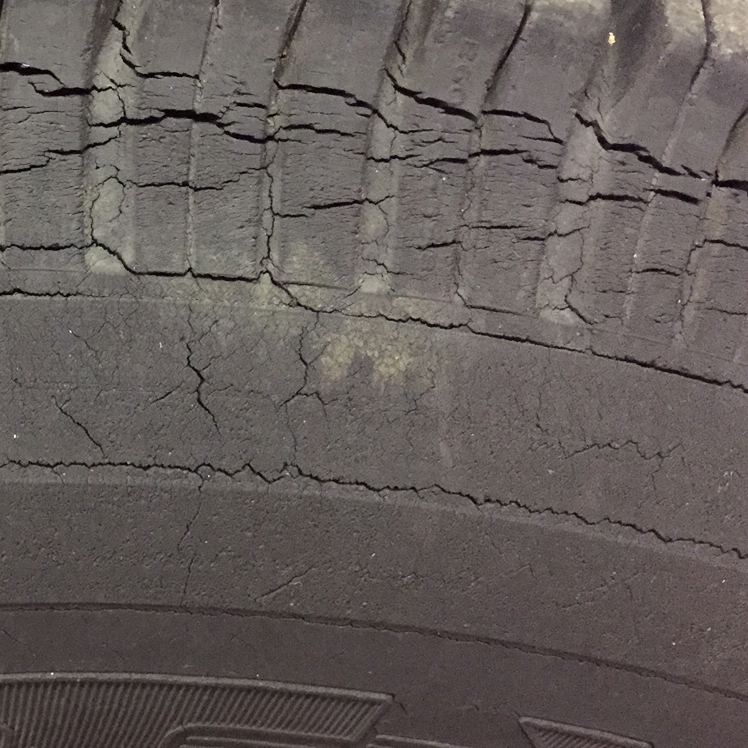

In [ ]:
img = Image.open(img_path)
img

In [ ]:
classes

['defective', 'good']

In [ ]:
import numpy as np

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
from PIL import ImageOps, ImageFilter
import torchvision.transforms.functional as F
from torchvision import transforms

In [ ]:
def image_transform():
    transform = transforms.Compose([
        transforms.Resize((256, 256)),           # Resize to 256x256
        transforms.Lambda(lambda img: img.filter(ImageFilter.MedianFilter(size=3))),  # Apply median filter
        transforms.Lambda(lambda img: ImageOps.equalize(img)),  # Histogram equalization
        transforms.ToTensor(),                   # Convert image to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for RGB
    ])
    return transform


In [ ]:
transform = image_transform()

In [ ]:
import torchvision
def load_dataset(path,transform_img):
  data = torchvision.datasets.ImageFolder(root=path, transform=transform)
  return data

In [ ]:
training_dataset = load_dataset(training_dataset_path,transform)
training_dataset

Dataset ImageFolder
    Number of datapoints: 1653
    Root location: /content/drive/MyDrive/Tyre Quality/training
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               Lambda()
               Lambda()
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [ ]:
testing_dataset = load_dataset(testing_dataset_path,transform)
testing_dataset

Dataset ImageFolder
    Number of datapoints: 202
    Root location: /content/drive/MyDrive/Tyre Quality/testing
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               Lambda()
               Lambda()
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

In [ ]:
def show_transformed_image(image_path, transform):
    # Load image
    img = Image.open(image_path)

    # Apply the transformations
    transformed_img = transform(img)

    # Convert the tensor back to numpy array for visualization
    img_np = transformed_img.numpy().transpose((1, 2, 0))  # Convert to HWC format for matplotlib

    # Undo normalization to bring values back to [0, 1] range
    img_np = img_np * 0.5 + 0.5  # Reverse normalization: img_np = (img_np * std + mean)

    # Display the transformed image
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

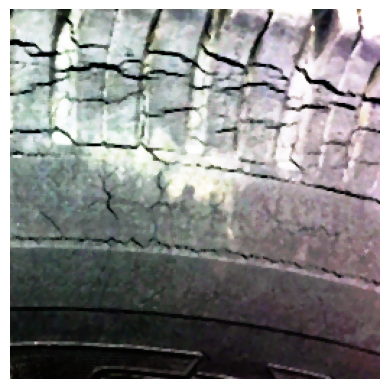

In [ ]:
# Get the image transformation pipeline
transform = image_transform()

# Show the transformed image
show_transformed_image(img_path, transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 16,shuffle=True)

In [ ]:
from torch.utils.data import SubsetRandomSampler,DataLoader,Dataset

In [ ]:
dataset_size = len(testing_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.3 * dataset_size)) #0.2 - 30:70 Ratio
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
test_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_loader = torch.utils.data.DataLoader(dataset = testing_dataset,batch_size = 16,sampler=test_sampler,shuffle=False)
val_loader = DataLoader(dataset= testing_dataset, shuffle=False, batch_size=16, sampler=val_sampler)

In [ ]:
import torch.nn as nn
import torchvision.models as models

In [ ]:
vgg = models.vgg16(pretrained=True)
vgg_features = nn.Sequential(*list(vgg.children())[:-1])
vgg_features.eval()

for param in vgg_features.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 51.0MB/s]


In [ ]:
def extract_features(loader, model):
    features_list = []
    with torch.no_grad():  # No need to compute gradients for feature extraction
        for images, _ in loader:
            # Pass the images through the VGG model to get the features
            features = model(images)
            features_list.append(features.cpu().numpy())
    return features_list

In [ ]:
train_features = extract_features(test_loader, vgg_features)
val_features = extract_features(val_loader, vgg_features)

In [ ]:
train_features = torch.tensor(np.concatenate(train_features, axis=0))
val_features = torch.tensor(np.concatenate(val_features, axis=0))

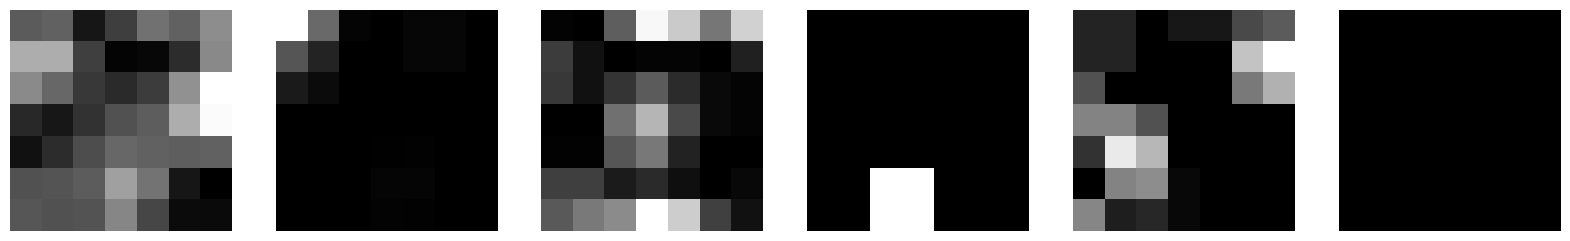

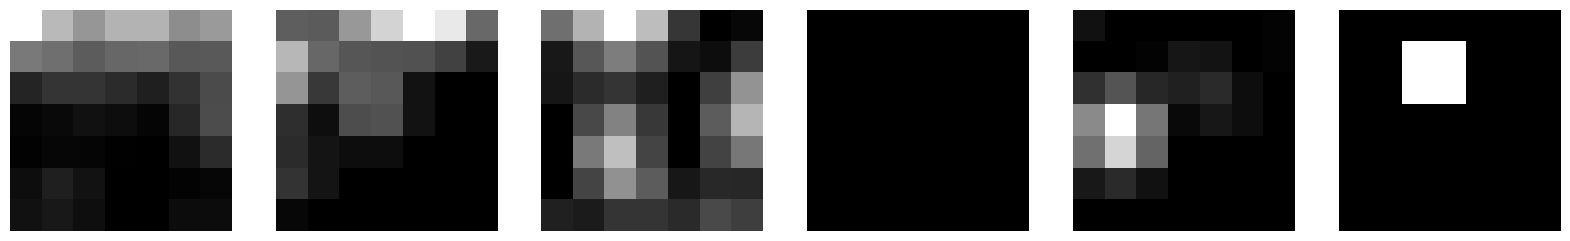

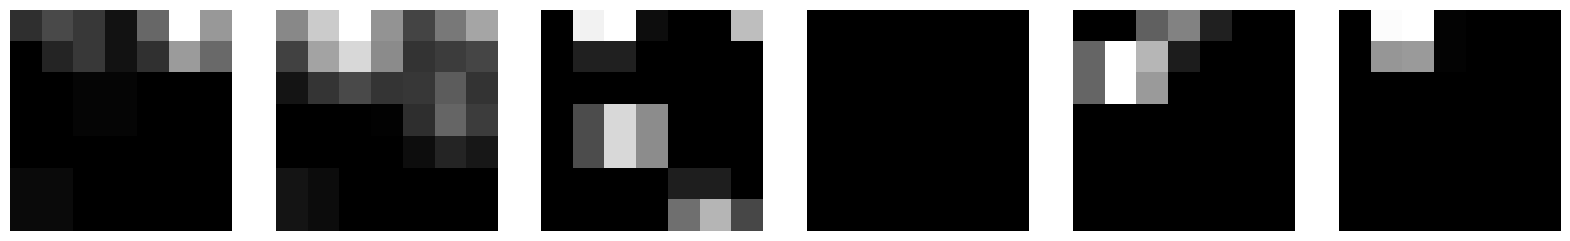

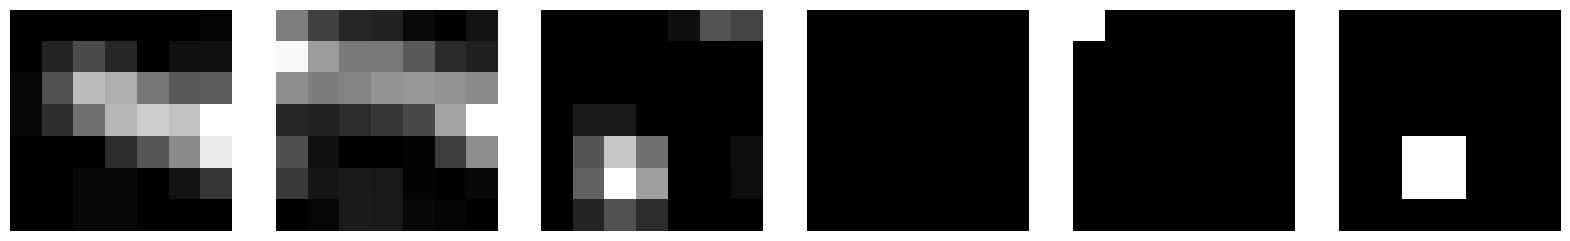

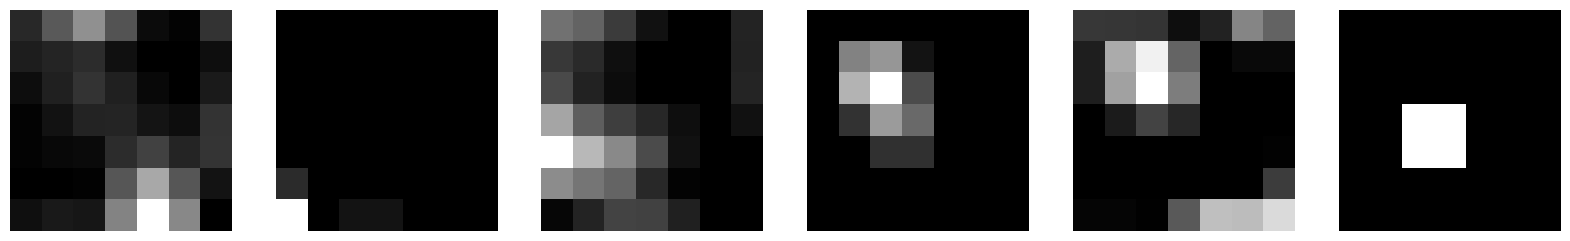

In [ ]:
import matplotlib.pyplot as plt

def visualize_feature_maps(features, num_images=5, num_channels=6):

    batch_features = features[:num_images]
    for i in range(num_images):
        fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))
        for j in range(num_channels):
            axes[j].imshow(batch_features[i][j].detach().numpy(), cmap='gray')
            axes[j].axis('off')
        plt.show()

visualize_feature_maps(train_features, num_images=5, num_channels=6)


In [ ]:
import torch.nn.functional as F

def overlay_feature_map_on_image(features, original_image, num_channels=6):
    upsampled_features = F.interpolate(features.unsqueeze(0), size=original_image.size()[1:], mode='bilinear')
    upsampled_features = upsampled_features.squeeze(0)  # Remove batch dimension

    fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))
    for j in range(num_channels):
        axes[j].imshow(original_image.squeeze(0).cpu().numpy(), cmap='gray')  # Original image
        axes[j].imshow(upsampled_features[j].cpu().detach().numpy(), alpha=0.5, cmap='jet')  # Overlay feature map
        axes[j].axis('off')
    plt.show()

# Example: Overlay the feature map on the first image of your test_loader
sample_image, _ = next(iter(test_loader))  # Get an image from the test_loader
sample_features = vgg_features(sample_image)
overlay_feature_map_on_image(sample_features, sample_image, num_channels=6)


NotImplementedError: Got 5D input, but bilinear mode needs 4D input